<a href="https://colab.research.google.com/github/irkian/Brain_Tumor_Classifier/blob/main/BrainTumorClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

In [3]:
projectName = 'BrainTumorClassification'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
dataDir ='/content/drive/My Drive/Colab Notebooks/BrainTumorClassification'


In [6]:
print(os.listdir(dataDir))
classes = os.listdir(dataDir+'/Training')
print(classes)

['Testing', 'Training', 'BrainTumorClassifier.ipynb']
['pituitary', 'notumor', 'meningioma', 'glioma']


In [7]:
meningioma_train = os.listdir(dataDir+'/Training/meningioma')
print('No. of training data for meningioma: ', len(meningioma_train))

No. of training data for meningioma:  1339


In [8]:
meningioma_test = os.listdir(dataDir+'/Testing/meningioma')
print('No. of training data for meningioma: ', len(meningioma_test))

No. of training data for meningioma:  306


In [9]:
meningioma_test[:5]

['Te-meTr_0007.jpg',
 'Te-meTr_0008.jpg',
 'Te-meTr_0003.jpg',
 'Te-meTr_0009.jpg',
 'Te-me_0012.jpg']

In [10]:
glioma_train = os.listdir(dataDir+'/Training/glioma')
print('No. of training data for glioma: ', len(glioma_train))

No. of training data for glioma:  1321


In [11]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

5712

In [21]:
trainData = ImageFolder(dataDir + '/Training', transform = torchvision.transforms.ToTensor(), target_transform=None)

In [22]:
testData= ImageFolder(dataDir + '/Testing', transform = torchvision.transforms.ToTensor(), target_transform=None)

In [23]:
len(trainData)

5712

In [24]:
len(testData)

1311

In [25]:
image, label = trainData[0]
image, label

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 0)

In [27]:
className = trainData.classes
className

['glioma', 'meningioma', 'notumor', 'pituitary']

In [28]:
classToIdx = trainData.class_to_idx
classToIdx

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [31]:
#checking shape of image
print(f'Image Shape: {image.shape} -> [color_channels, height, width]')

Image Shape: torch.Size([3, 512, 512]) -> [color_channels, height, width]


Image Shape: torch.Size([3, 512, 512])


TypeError: ignored

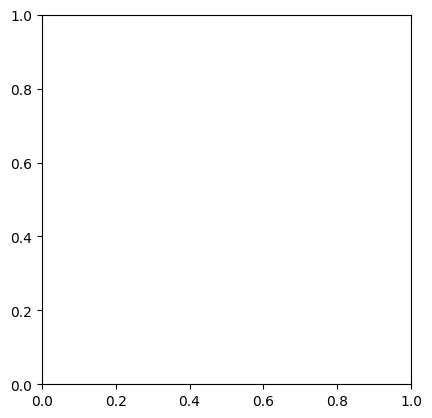

In [36]:
#visulizaing the images
import matplotlib.pyplot as plt
image, label = trainData[0]
print(f'Image Shape: {image.shape}')
plt.imshow(image)
image

TypeError: ignored

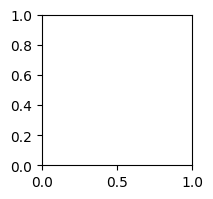

In [42]:
#plot more images
# torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4,4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(trainData), size= [1]).item()
  img, label =trainData[random_idx]
  fig.add_subplot(rows, cols ,i)
  plt.imshow(img.squeeze(), cmap='gray')
  plt.title(className[label])
  plt.axis(False);


In [45]:
#Data Loader

#Data Loader turns dataset into python iterables and turn data into mini batches

# computationally efficient, some somputer hardware may not be able to look at 60,000 images in one hit.
# it gives our neural network more chance to update its gradients per epoch

In [50]:
from torch.utils.data.dataloader import DataLoader

BatchSize = 32

trainDataLoader = DataLoader( dataset= trainData,
                             batch_size= BatchSize,
                              shuffle= True)
testDataLoader = DataLoader(dataset=testData,
                            batch_size=BatchSize,
                            shuffle=False)

trainDataLoader, testDataLoader

(<torch.utils.data.dataloader.DataLoader at 0x79b05c1f2fb0>,
 <torch.utils.data.dataloader.DataLoader at 0x79b05c1f1450>)

In [51]:
print(f'DataLoaders: {trainDataLoader, testDataLoader}')
print(f'Length of train data loader : {len(trainDataLoader)} batches of {BatchSize}')
print(f'Length of test data loader : {len(testDataLoader)} batches of {BatchSize}')

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x79b05c1f2fb0>, <torch.utils.data.dataloader.DataLoader object at 0x79b05c1f1450>)
Length of train data loader : 179 batches of 32
Length of test data loader : 41 batches of 32


In [52]:
trainFeatureBatch, trainLabelBatch = next(iter(trainDataLoader))
trainFeatureBatch.shape, trainLabelBatch.shape

RuntimeError: ignored

In [ ]:
#Sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(trainFeatureBatch))